In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arc
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import solve_ivp
from scipy.interpolate import RegularGridInterpolator
import time 

# --- Global Constants ---
LAMBDA_0 = 0.5
K0 = 2 * np.pi / LAMBDA_0
R_SCHWARZSCHILD = 5.0
MASS_M = R_SCHWARZSCHILD / 2.0

class MaxwellFDFD:
    def __init__(self, L, resolution, pml_width):
        self.L = L
        self.resolution = resolution
        self.dx = 1.0 / (resolution)
        self.Nx = int(L * resolution)
        self.Ny = int(L * resolution)
        self.shape = (self.Nx, self.Ny)
        self.npml = int(pml_width * resolution)

        self.x = np.linspace(-L/2, L/2, self.Nx)
        self.y = np.linspace(-L/2, L/2, self.Ny)
        self.X, self.Y = np.meshgrid(self.x, self.y, indexing='ij')

        self.epsilon = np.ones(self.shape, dtype=np.complex128)
        self.source = np.zeros(self.shape, dtype=np.complex128)

    def _make_derivative_matrices(self, N):
        e = np.ones(N)
        D = sp.spdiags([-e, e], [0, 1], N, N) / self.dx
        return D

    def _create_pml_stretch(self, N, npml):
        sigma = np.zeros(N)
        if npml > 0:
            idx = np.arange(npml)
            prof = (idx / npml) ** 2
            sigma[0:npml] = prof[::-1]
            sigma[-npml:] = prof
        return 1.0 + 1j * sigma

    def get_poynting_vector(self, Ez):
        Dx_1d = self._make_derivative_matrices(self.Nx)
        Dy_1d = self._make_derivative_matrices(self.Ny)
        Dx_cent = 0.5 * (Dx_1d - Dx_1d.transpose())
        Dy_cent = 0.5 * (Dy_1d - Dy_1d.transpose())
        Op_diff_x = sp.kron(Dx_cent, sp.eye(self.Ny))
        Op_diff_y = sp.kron(sp.eye(self.Nx), Dy_cent)
        Ez_flat = Ez.flatten()
        dEz_dx = (Op_diff_x @ Ez_flat).reshape(self.shape)
        dEz_dy = (Op_diff_y @ Ez_flat).reshape(self.shape)
        Hx = (1 / (1j * K0)) * dEz_dy
        Hy = -(1 / (1j * K0)) * dEz_dx
        Sx = np.real(-0.5 * Ez * np.conj(Hy))
        Sy = np.real( 0.5 * Ez * np.conj(Hx))
        return Sx, Sy

    def solve(self):
        print(f"Building matrix ({self.Nx}x{self.Ny})...")
        
        start_build = time.time()
        
        sx = self._create_pml_stretch(self.Nx, self.npml)
        sy = self._create_pml_stretch(self.Ny, self.npml)
        Ix = sp.diags(1.0 / sx); Iy = sp.diags(1.0 / sy)
        Dx = self._make_derivative_matrices(self.Nx); 
        Dy = self._make_derivative_matrices(self.Ny)
        Dxf = Dx; Dxb = -Dx.transpose(); Dyf = Dy; Dyb = -Dy.transpose()
        Lxx_1d = (Ix @ Dxb) @ (Ix @ Dxf); Lyy_1d = (Iy @ Dyb) @ (Iy @ Dyf)
        Lxx = sp.kron(sp.eye(self.Ny), Lxx_1d); Lyy = sp.kron(Lyy_1d, sp.eye(self.Nx))
        Laplacian = Lxx + Lyy
        A = Laplacian + (K0**2) * sp.diags(self.epsilon.flatten())
        b = -1j * K0 * self.source.flatten()
        end_build = time.time()
        print(f"Matrix built in {end_build - start_build:.2f} seconds.")
        print("Solving...")
        start_solve = time.time()
        solver = spl.splu(A.tocsc())
        E_z = solver.solve(b).reshape(self.shape)
        end_solve = time.time()
        print(f"Solved in {end_solve - start_solve:.2f} seconds.")
        return E_z

def get_newman(R_grid, M, b_inf, R_outer, a_hat=0.0, Q_hat=0.0, prograde=True):
    rho = np.array(R_grid) / M
    inv_b_inf = 1.0 / b_inf
    sgn = 1.0 if prograde else -1.0
    rho_Q2 = Q_hat**2
    Delta = rho**2 - 2.0*rho + a_hat**2 + rho_Q2
    A = (rho**2 + a_hat**2)**2 - a_hat**2 * Delta
    term_a = a_hat * (2.0*rho - rho_Q2) 

    V_plus  = (term_a + sgn * (rho**2) * np.sqrt(Delta)) / A
    V_minus = (term_a - sgn * (rho**2) * np.sqrt(Delta)) / A
    T_bracket = (Delta - a_hat**2) + (2.0*rho - rho_Q2) * a_hat * inv_b_inf

    num = rho**2 * T_bracket
    termV = (inv_b_inf - V_plus) * (inv_b_inf - V_minus)
    denom_inside = (rho**2) * (T_bracket**2) + (Delta**2) * A * termV


    denom_inside = np.maximum(denom_inside, 1e-15) 

    b_hat = num / np.sqrt(denom_inside)
    n_raw = 1.0 / b_hat

    # Normalisation
    rho_o = R_outer / M
    Delta_o = rho_o**2 - 2*rho_o + a_hat**2 + rho_Q2
    sqrt_o = np.sqrt(Delta_o)
    A_o = (rho_o**2 + a_hat**2)**2 - a_hat**2 * Delta_o
    term_a_o = a_hat * (2.0*rho_o - rho_Q2)
    Vp_o = (term_a_o + sgn * rho_o**2 * sqrt_o) / A_o
    Vm_o = (term_a_o - sgn * rho_o**2 * sqrt_o) / A_o
    T_o = (Delta_o - a_hat**2) + (2.0*rho_o - rho_Q2) * a_hat * inv_b_inf
    denom_o = rho_o**2 * T_o**2 + Delta_o**2 * A_o * (inv_b_inf - Vp_o)*(inv_b_inf - Vm_o)
    
    # Safety
    denom_o = np.maximum(denom_o, 1e-15)

    b_hat_o = (rho_o**2 * T_o) / np.sqrt(denom_o)
    
    norm = 1.0 / b_hat_o
    
    return n_raw / norm

def compute_geodesic_trajectory(M, b_inf, a_hat, Q_hat, R_outer, r_end, prograde=True):
    """
    Computes the complete geodesic (entry and exit) using the affine parameter
    to avoid the singularity at the periastron (turning point).
    """
    rho_start = R_outer / M
    inv_b = 1.0 / b_inf
    sgn_l = 1.0 if prograde else -1.0 
    rho_Q2 = Q_hat**2

    def get_metric_terms(rho):
        Delta = rho**2 - 2*rho + a_hat**2 + rho_Q2
        A_metric = (rho**2 + a_hat**2)**2 - a_hat**2 * Delta
        return Delta, A_metric

    def get_potential_and_flux(rho):
        Delta, A_metric = get_metric_terms(rho)
        
        num_phi = ( (1 - 2/rho + rho_Q2/rho**2)*b_inf + (2*a_hat/rho - rho_Q2*a_hat/rho**2) ) / Delta

        # Calculation of the Radial Potential R (term_R)
        sqrt_Delta = np.sqrt(np.maximum(Delta, 0)) # Sécurité num.
        term_a = a_hat * (2.0*rho - rho_Q2)
        V_plus  = (term_a + sgn_l * (rho**2) * sqrt_Delta) / A_metric
        V_minus = (term_a - sgn_l * (rho**2) * sqrt_Delta) / A_metric
        
        # Effective Radial Potential
        R_pot = (A_metric / rho**4) * (b_inf**2) * (inv_b - V_plus) * (inv_b - V_minus)
        
        return R_pot, num_phi

    def get_radial_force(rho):
        """Analytical derivative of the radial potential R with respect to rho"""
        Delta = rho**2 - 2*rho + a_hat**2 + rho_Q2
        sqrt_Delta = np.sqrt(np.maximum(Delta, 1e-15))
        A_metric = (rho**2 + a_hat**2)**2 - a_hat**2 * Delta
        
        # Derivatives of basic terms
        dDelta_drho = 2*rho - 2
        dA_drho = 4*rho*(rho**2 + a_hat**2) - a_hat**2 * dDelta_drho
        dsqrtDelta_drho = dDelta_drho / (2 * sqrt_Delta) if sqrt_Delta > 1e-10 else 0
        
        # V_plus and V_minus terms
        term_a = a_hat * (2.0*rho - rho_Q2)
        dterm_a_drho = 2 * a_hat
        
        numerator_plus = term_a + sgn_l * rho**2 * sqrt_Delta
        numerator_minus = term_a - sgn_l * rho**2 * sqrt_Delta
        
        dnumer_plus_drho = dterm_a_drho + sgn_l * (2*rho*sqrt_Delta + rho**2*dsqrtDelta_drho)
        dnumer_minus_drho = dterm_a_drho - sgn_l * (2*rho*sqrt_Delta + rho**2*dsqrtDelta_drho)
        
        V_plus = numerator_plus / A_metric
        V_minus = numerator_minus / A_metric
        
        # Derivatives of V using quotient rule
        dV_plus_drho = (dnumer_plus_drho * A_metric - numerator_plus * dA_drho) / (A_metric**2)
        dV_minus_drho = (dnumer_minus_drho * A_metric - numerator_minus * dA_drho) / (A_metric**2)
        
        # R_pot = (A_metric / rho**4) * b_inf**2 * (inv_b - V_plus) * (inv_b - V_minus)
        factor1 = A_metric / rho**4
        factor2 = (inv_b - V_plus) * (inv_b - V_minus)
        
        dfactor1_drho = (dA_drho * rho**4 - A_metric * 4 * rho**3) / (rho**8)
        dfactor2_drho = -dV_plus_drho * (inv_b - V_minus) - (inv_b - V_plus) * dV_minus_drho
        
        dR_drho = b_inf**2 * (dfactor1_drho * factor2 + factor1 * dfactor2_drho)
        
        return dR_drho
    
    def equations_of_motion(t, y):
        rho, v_rho, phi = y
        
        if rho < 1.05 * (1 + np.sqrt(1 - a_hat**2 - rho_Q2)):
             return [0, 0, 0]

        R_pot, ang_flux = get_potential_and_flux(rho)
        force = 0.5 * get_radial_force(rho)
        
        return [v_rho, force, ang_flux]

    # Initial conditions
    x_start_phys = b_inf * M
    y_start_sq = R_outer**2 - x_start_phys**2
    if y_start_sq < 0:
        raise ValueError("Impact parameter too large, no valid starting point.")
    y_start_phys = -np.sqrt(y_start_sq)
    phi0 = np.arctan2(y_start_phys, x_start_phys)

    # Initial velocity
    R_start, _ = get_potential_and_flux(rho_start)
    if R_start < 0: R_start = 0
    v_rho_start = -np.sqrt(R_start) # < 0 because we start going inward

    y0 = [rho_start, v_rho_start, phi0]

    # Event to stop when exiting the simulation zone
    def exit_condition(t, y):
        rho = y[0]
            # On s'arrête si on dépasse R_outer ET qu'on s'éloigne (v_rho > 0)
        if rho > rho_start + 0.1 and y[1] > 0 or rho <= r_end / M:
            return 0.0
        return 1.0
    exit_condition.terminal = True
    exit_condition.direction = -1 # Trigger when the function goes from + to 0

    # Integrate over an arbitrarily long duration (lambda)
    # The solver will stop thanks to exit_condition
    t_span = [0, 200.0] 
    
    sol = solve_ivp(equations_of_motion, t_span, y0, events=exit_condition, 
                    rtol=1e-9, atol=1e-9, max_step=0.1)

    rhos = sol.y[0]
    phis = sol.y[2]
    
    X_geo = rhos * np.cos(phis) * M
    Y_geo = rhos * np.sin(phis) * M
    
    return X_geo, Y_geo

def compute_poynting_centroid(Sx, Sy, sim_x, sim_y, X_geo, Y_geo, width=3.0, num_samples=30):
    """
    Calculates the centroid of the energy flux (Poynting) along cuts 
    orthogonal to the geodesic.
    """
    # Prepare interpolation
    # Sx and Sy are on the grid (Nx, Ny) corresponding to (sim.x, sim.y)
    mag_S = np.sqrt(Sx**2 + Sy**2)
    
    # RegularGridInterpolator expects (x_axis, y_axis)
    interp_S = RegularGridInterpolator((sim_x, sim_y), mag_S, bounds_error=False, fill_value=0.0)
    
    X_eff = []
    Y_eff = []
    
    # Skip the last point so we can compute the tangent
    for i in range(len(X_geo) - 1):
        x_curr, y_curr = X_geo[i], Y_geo[i]
        x_next, y_next = X_geo[i+1], Y_geo[i+1]
        
        # Tangent vector
        tx = x_next - x_curr
        ty = y_next - y_curr
        norm_t = np.hypot(tx, ty)
        if norm_t == 0: continue
        tx /= norm_t
        ty /= norm_t
        
        # Normal vector (90 deg rotation)
        nx = -ty
        ny = tx
        
        # Create the cut line (sampling)
        # s varies from -width/2 to +width/2
        s_vals = np.linspace(-width/2, width/2, num_samples)
        
        sample_x = x_curr + nx * s_vals
        sample_y = y_curr + ny * s_vals
        
        # Interpolate Poynting on the cut
        # points shape: (num_samples, 2)
        points = np.column_stack((sample_x, sample_y))
        S_vals = interp_S(points)
        
        # Compute the centroid (center of mass)
        total_S = np.sum(S_vals)
        
        if total_S > 1e-6: # Avoid division by zero if no energy
            avg_x = np.sum(sample_x * S_vals) / total_S
            avg_y = np.sum(sample_y * S_vals) / total_S
            X_eff.append(avg_x)
            Y_eff.append(avg_y)
        else:
            # If no energy, keep the geodesic (or stop)
            X_eff.append(x_curr)
            Y_eff.append(y_curr)
            
    return np.array(X_eff), np.array(Y_eff)

def run_experiment(b_inf, num_annuli, resolution,a_hat=0.0, Q_hat=0.0):
    print(f"\n=== Simulation : [a={a_hat}, Q={Q_hat}, b={b_inf}] ===")

    L = 35.0
    RES = resolution
    PML_W = 1.0
    
    sim = MaxwellFDFD(L, RES, PML_W)
    R_grid = np.sqrt(sim.X**2 + sim.Y**2)
    R_outer = 6.0 * MASS_M
    
    rho_Q2_total = Q_hat**2
    delta_horizon = 1.0 - a_hat**2 - rho_Q2_total
    
    if delta_horizon < 0: r_plus_hat = 1.0 
    else: r_plus_hat = 1.0 + np.sqrt(delta_horizon)
    R_h = r_plus_hat * MASS_M

    # --- Device setup (annuli) ---
    inv_b = 1.0 / b_inf
    term1 = 1.0 - a_hat * inv_b
    delta_star = term1 * (term1 - rho_Q2_total)
    p_star_hat = -1.0 
    if delta_star >= 0:
        p_star_val = term1 + np.sqrt(delta_star)
        if p_star_val > r_plus_hat: p_star_hat = p_star_val

    safety_margin = 0.08
    if p_star_hat > r_plus_hat:
        r_start_hat = p_star_hat + safety_margin
    else:
        r_start_hat = r_plus_hat + safety_margin

    R_inner_device = r_start_hat * MASS_M

    total_width = R_outer - R_inner_device
    dr_standard = total_width / (num_annuli - 1)
    
    n_map = np.ones(sim.shape)
    r_boundaries = [R_inner_device] 
    n_val_list = []
    
    current_r = R_inner_device
    for i in range(num_annuli):
        width = dr_standard / 2.0 if (i == 0 or i == num_annuli - 1) else dr_standard
        r_in = current_r; r_out = current_r + width; r_mid = (r_in + r_out) / 2.0
        query_r = r_in if i==0 else (r_out if i==num_annuli-1 else r_mid)

        val = get_newman(query_r, MASS_M, b_inf, R_outer, a_hat, Q_hat)
        mask_ring = (R_grid >= r_in) & (R_grid < r_out)
        n_map[mask_ring] = val
        n_val_list.append(val)
        current_r += width
        r_boundaries.append(current_r)

    if np.any(np.isnan(n_map)): n_map = np.nan_to_num(n_map, nan=1.0)
    sim.epsilon = n_map**2
    sim.epsilon = sim.epsilon.astype(np.complex128)

    # --- Internal absorption ---
    mask_hole = R_grid < R_inner_device
    n_inner_val = n_val_list[0] if len(n_val_list) > 0 else 1.0
    sim.epsilon[mask_hole] = (n_inner_val**2) + 1j * np.pi

    # --- Waveguide ---
    y_source_loc = -L/2 + PML_W + 0.5
    x_beam_center = b_inf * MASS_M
    beam_width = 2.0 * LAMBDA_0
    
    in_beam_path = np.abs(sim.X - x_beam_center) < (beam_width / 2.0)
    inside_device = R_grid < R_outer
    mask_guide = (~inside_device) & (~in_beam_path)
    sim.epsilon[mask_guide] = 1.0
    
    wall_thickness = 0.2
    left_wall = (sim.X >= x_beam_center - beam_width/2 - wall_thickness) & (sim.X < x_beam_center - beam_width/2)
    right_wall = (sim.X > x_beam_center + beam_width/2) & (sim.X <= x_beam_center + beam_width/2 + wall_thickness)
    mask_walls = (~inside_device) & (left_wall | right_wall) & (sim.Y < 0)
    sim.epsilon[mask_walls] = 1.0 + 1j * np.pi

    # --- Solver ---
    print("Computing FDFD solution...")
    j_src = int((y_source_loc + L/2) * RES)
    delta_beam = LAMBDA_0 / 2.0
    ampl = np.exp(-(sim.x - x_beam_center)**2 / (2 * delta_beam**2))
    sim.source[:, j_src] = ampl 
    Ez = sim.solve()

    Sx, Sy = sim.get_poynting_vector(Ez)
    
    # 1. Theoretical geodesic (starting from R_outer)
    X_geo, Y_geo = compute_geodesic_trajectory(MASS_M, b_inf, a_hat, Q_hat, R_outer, r_start_hat*MASS_M + 0.1)

    # 2. Effective trajectory (Poynting average)
    print("Compute mean trajectory of Poynting vector...")
    cut_width = 4 * resolution * L 
    X_eff, Y_eff = compute_poynting_centroid(Sx, Sy, sim.x, sim.y, X_geo, Y_geo, width=cut_width)

    # 3. Save data for analysis in another script
    print("Saving data...")
    output_data = {
        'parameters': {
            'b_inf': b_inf,
            'a_hat': a_hat,
            'Q_hat': Q_hat,
            'num_annuli': num_annuli,
            'L': L,
            'resolution': RES,
            'R_outer': R_outer,
            'R_inner_device': R_inner_device,
            'R_h': R_h,
            'MASS_M': MASS_M,
            'LAMBDA_0': LAMBDA_0
        },
        'simulation_grid': {
            'x': sim.x,
            'y': sim.y,
            'X': sim.X,
            'Y': sim.Y,
            'R_grid': R_grid
        },
        'fields': {
            'Ez': Ez,
            'Sx': Sx,
            'Sy': Sy
        },
        'device': {
            'n_map': n_map,
            'epsilon': sim.epsilon,
            'r_boundaries': r_boundaries,
            'n_val_list': n_val_list
        },
        'trajectories': {
            'X_geo': X_geo,
            'Y_geo': Y_geo,
            'X_eff': X_eff,
            'Y_eff': Y_eff
        }
    }
    
    filename = f'fdfd_data_a{a_hat}_Q{Q_hat}_b{b_inf}_n{num_annuli}_res{resolution}.npz'
    np.savez_compressed(filename, **output_data)
    print(f"Data saved to {filename}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Arc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import os


def load_simulation_data(filename):
    """
    Load simulation data from NPZ file.
    
    Args:
        filename: Path to the .npz file
    
    Returns:
        Dictionary containing all simulation data
    """
    print(f"Loading data from {filename}...")
    data = np.load(filename, allow_pickle=True)
    
    # Convert NPZ structure to dictionary
    result = {}
    for key in data.files:
        result[key] = data[key]
    
    print("Data loaded successfully!")
    return result


def plot_simulation(data, save=True):
    """
    Generate visualization from loaded simulation data.
    
    Args:
        data: Dictionary containing simulation data
        save: If True, save the figure with parameters in the filename
    """
    # Extract parameters
    params = data['parameters'].item()
    sim_grid = data['simulation_grid'].item()
    fields = data['fields'].item()
    device = data['device'].item()
    trajectories = data['trajectories'].item()
    
    # Unpack variables
    L = params['L']
    b_inf = params['b_inf']
    a_hat = params['a_hat']
    Q_hat = params['Q_hat']
    R_h = params['R_h']
    LAMBDA_0 = params['LAMBDA_0']
    resolution = params['resolution']
    
    X = sim_grid['X']
    Y = sim_grid['Y']
    R_grid = sim_grid['R_grid']
    
    Ez = fields['Ez']
    Sx = fields['Sx']
    Sy = fields['Sy']
    
    r_boundaries = device['r_boundaries']
    
    X_geo = trajectories['X_geo']
    Y_geo = trajectories['Y_geo']
    X_eff = trajectories['X_eff']
    Y_eff = trajectories['Y_eff']
    
    # Create figure
    extent = [-L/2, L/2, -L/2, L/2]
    fig, ax = plt.subplots(figsize=(7, 6))
    mag = np.abs(Ez)
    mag_normalized = mag / np.max(mag)
    
    im2 = ax.imshow(mag_normalized.T, origin='lower', extent=extent, cmap='viridis', vmin=0, vmax=0.5)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im2, cax=cax, label='|E| (norm)')
    
    # Drawing the annuli
    theta_center = 225; theta_width = 18
    theta1 = theta_center - theta_width/2; theta2 = theta_center + theta_width/2
    for i, r_b in enumerate(r_boundaries):
        if i == 0 or i == len(r_boundaries) - 1:
            lw = 0.8 if i == len(r_boundaries) - 1 else 0.5
            alpha = 0.6 if i == len(r_boundaries) - 1 else 0.4
            ax.add_patch(Circle((0,0), r_b, color='white', fill=False, ls='-', linewidth=lw, alpha=alpha))
        else:
            ax.add_patch(Arc((0,0), 2*r_b, 2*r_b, angle=0, theta1=theta1, theta2=theta2, 
                                 color='white', ls='-', linewidth=0.5, alpha=0.5))
    
    # --- POYNTING QUIVER ---
    step = int(params['resolution'])
    sl_x = slice(0, None, step); sl_y = slice(None, None, step)
    R_safe = R_grid.copy()
    R_sub = R_safe[sl_x, sl_y]
    R_sub[R_sub < 0.1] = 0.1 
    U_raw = Sx[sl_x, sl_y] / R_sub; V_raw = Sy[sl_x, sl_y] / R_sub
    
    X_sub = X[sl_x, sl_y]; Y_sub = Y[sl_x, sl_y]
    R_limit_draw = r_boundaries[-1] 
    mask_in = np.sqrt(X_sub**2 + Y_sub**2) <= R_limit_draw
    
    U_in = U_raw[mask_in]; V_in = V_raw[mask_in]
    X_in = X_sub[mask_in]; Y_in = Y_sub[mask_in]
    
    max_val = np.max(np.hypot(U_in, V_in)) if len(U_in) > 0 else 1.0
    ax.quiver(X_in, Y_in, U_in/max_val, V_in/max_val, color='white', pivot='tail', scale=10)
    
    # --- TRAJECTORY PLOTS ---
    # 1. Geodesic (white dashed)
    ax.plot(X_geo, Y_geo, color='white', linewidth=5, linestyle='--', alpha=0.8, label='Geodesic (Theory)')
    
    # 2. Effective Poynting (solid red)
    ax.plot(X_eff, Y_eff, color='red', linewidth=2.0, alpha=1.0, label='Poynting Avg (Sim)')
    
    # Decorative elements
    ax.add_patch(Circle((0,0), R_h, color='white', fill=False, ls='-', linewidth=2))
    ax.add_patch(Circle((0,0), R_h, color='black', fill=True))
    ax.text(-R_h + 0.5, 0, r'$R_h$', color='white', fontsize=12)
    
    label_text = r'$\hat{b}_{\infty} = ' + f'{b_inf}' + r'$' if (a_hat==0 and Q_hat==0) else r'$\hat{a}=' + f'{a_hat}' + r', \rho_Q=' + f'{Q_hat}' + r'$'
    ax.text(-L/2 + 1, -L/2 + 1, label_text, color='white', fontsize=14)
    
    ax.legend(loc='upper left', fontsize=10, framealpha=0.5, facecolor='black', edgecolor='white', labelcolor='white')
    ax.axis('off')
    plt.tight_layout()
    
    # Save figure with parameters in filename
    if save:
        fig_filename = f'fdfd_plot_a{a_hat}_Q{Q_hat}_b{b_inf}_res{resolution}.pdf'
        plt.savefig(fig_filename, dpi=150, bbox_inches='tight', facecolor='black')
        print(f"Figure saved to {fig_filename}")
    
    plt.show()


def find_latest_data_file():
    """
    Find the most recent .npz file in the current directory.
    
    Returns:
        Path to the most recent .npz file, or None if not found
    """
    files = glob.glob('fdfd_data_*.npz')
    if not files:
        return None
    return max(files, key=os.path.getctime)

Loading data from fdfd_data_a0_Q0_b5_n16_res30.npz...
Data loaded successfully!
Figure saved to fdfd_plot_a0_Q0_b5_res30.pdf


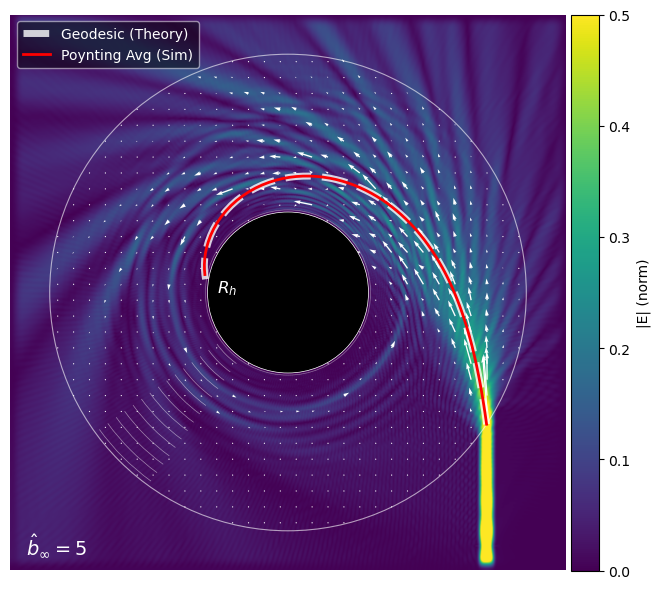

In [114]:
b_inf = 5
num_annuli = 16
resolution = 30
a_hat = 0
Q_hat = 0

if __name__ == "__main__":
    # run_experiment(b_inf=b_inf, num_annuli=num_annuli, resolution=resolution, a_hat=a_hat, Q_hat=Q_hat)

    data_file = find_latest_data_file()

    data = load_simulation_data(data_file)
    plot_simulation(data, save=True)